# Task 3

For task 3 we implemented the sentence-BERT model architecture taken from Reimers, N., & Gurevych, I. (2019).
This siamese network architecure does away with the LSTM and self-attention layer entirely, relying almost completely on the transformer encoder.
Instead of the much more well-trained BERT transformer model, we used an implementation of our own custom transformer encoder.
Dor the pooling laer we decided to implement mean pooling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from test import evaluate_test_set
import sts_data
from importlib import reload
import numpy as np

## Part 1. Data pipeline

One change has been made to the data pipeline: the stop words are no longer being removed.
We found that the stop words actually add quite a bit of context to the sentences. For example, words like 'not' and 'isn't' that indicate negation.
Keeping the entire sentences increaed accuracy a lot.

In [3]:
reload(sts_data)
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 64

sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

INFO:root:loading and preprocessing data...
100%|██████████| 3/3 [00:00<00:00, 997.14it/s]
INFO:root:Four kids are doing backbends in the park
INFO:root:Four children are doing backbends in the park
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\NNTI_project\task3\preprocess.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_A'] = dataset['train']['sentence_A'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\NNTI_project\task3\preprocess.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_B'] = dataset['train']['sentence_B'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\NNTI_project\task3\preprocess.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['test']['sentence_A'] = dataset['test']

Testing vocab. Index for kids is 115
Testing vocab. Index for sentence ['a', 'group', 'of', 'kids', 'is', 'playing', 'in', 'a', 'yard', 'and', 'an', 'old', 'man', 'is', 'standing', 'in', 'the', 'background'] is [2, 64, 11, 115, 3, 13, 6, 2, 216, 7, 20, 275, 5, 3, 21, 6, 4, 212]
<unk>
<pad>
a
Index(['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score',
       'entailment_AB', 'entailment_BA', 'sentence_A_original',
       'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
      dtype='object')
max len a: 28, max_len b: 32, max_len 32
[2, 319, 3, 150, 2, 57, 23, 96, 3, 692, 2, 468, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
max len a: 28, max_len b: 30, max_len 30
[18, 3, 16, 19, 27, 2, 80, 7, 31, 9, 4, 44, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
max len a: 30, max_len b: 26, max_len 30
[83, 39, 46, 8, 1521, 29, 34, 7, 241, 54, 2, 1459, 260, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Part 2. Model Configuration & Hyperparameter Tuning

Once again we use our custom genetic algorithm to find goos hyperparameter values.
An advantage of this model is that much fewer hyperparameters have to be tuned.

In [4]:
hyper_param_search=True

output_size = 128
hidden_size = 403
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 4
learning_rate = 0.00048586475278877557
fc_hidden_size = 89
max_epochs = 200
bidirectional = True
dropout = 0.12354567224086944
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## self attention config
self_attention_config = {
    "hidden_size": 400,  ## refers to variable 'da' in the ICLR paper
    "output_size": 14,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.1965166853622733,  ## refers to penalty coefficient term in the ICLR paper
}

attention_encoder_config = {
    "n_layers": 4,  ## number of encoder layers
    "n_heads": 16,  ## heads in multi-head attention
    "expansion": 4, ## encoder feed forward embedding size expansion factor
    "vocab_max": 15 ## max sequence length
}
pad_index = sick_data.vocab.stoi['<pad>']

In [6]:
from train import train_model, genetic_hyperparam_search

if hyper_param_search:
    genetic_hyperparam_search(data_loader=sick_dataloaders, device=device, vocab_size=vocab_size, max_epochs=1, num_gens=3, pad_index=pad_index, embedding_weights=embedding_weights)

INFO:root:Finding best hyperparameters using genetic algorithm
INFO:root:starting generation 0
INFO:root:Starting train for model with parameters fc=256, dropout=0.17530260531893788, lr=0.001, e_layers=8, output_size=152, embedding_size=900


TypeError: __init__() got an unexpected keyword argument 'output_size'

## Part 3. Training 
Training the final model based off the hyperparameters found during tuning

In [9]:
## Best found hyperparams:hidden_size=80,lstm_layers=2,fc=76,dropout=1e-07,a_hs=98,a_os=21,p=0.7502554332823722, lr=2.225080318923014e-05, e_layers=1
## INFO:root:Starting train for model with parameters hidden_size=258,lstm_layers=2,fc=257,dropout=1e-07,a_hs=408,a_os=15,p=0.0, lr=3.967019319929535e-05, e_layers=4
##  hidden_size=511,lstm_layers=2,fc=423,dropout=0.0901198887332128,a_hs=428,a_os=19,p=0.0, lr=8e-05, e_layers=4

#### After some changes to model (mask)
## with parameters hidden_size=529,lstm_layers=4,fc=362,dropout=1e-07,a_hs=128,a_os=18,p=0.0, lr=0.0004930708179433092, e_layers=1, output_size=183


batch_size = 64
vocab_size = len(sick_data.vocab)
embedding_size = 300
learning_rate = 8e-05#0.0004930708179433092
max_epochs = 5
dropout = 0.166
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## encoder attention config
attention_encoder_config = {
    "n_layers": 12,  ## number of encoder layers
    "n_heads": 12,  ## heads in multi-head attention
    "expansion": 4, ## encoder feed forward embedding size expansion factor
    "vocab_max": 40 ## max sequence length
}

In [10]:
from siamese_lstm_attention import SiameseBiLSTMAttention
## init siamese lstm
siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    attention_encoder_config=attention_encoder_config,
    device=device,
    pad_index=pad_index,
    dropout=dropout
)

## move model to device
siamese_lstm_attention.to(device)

SiameseBiLSTMAttention(
  (word_embeddings): Embedding(2177, 300)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attention): MultiHeadSelfAttention(
          (Q): Linear(in_features=300, out_features=300, bias=False)
          (K): Linear(in_features=300, out_features=300, bias=False)
          (V): Linear(in_features=300, out_features=300, bias=False)
          (output_layer): Linear(in_features=300, out_features=300, bias=True)
        )
        (Dropout): Dropout(p=0.166, inplace=False)
        (LayerNorm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (LayerNorm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (FeedForward): Sequential(
          (0): Linear(in_features=300, out_features=1200, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1200, out_features=300, bias=True)
        )
      )
      (1): EncoderBlock(
        (attention): MultiHeadSelfAttention(
          (Q): Linear(in_features=

In [11]:
from train import train_model
torch.cuda.empty_cache()
optimizer = torch.optim.Adam(params=siamese_lstm_attention.parameters(), lr=learning_rate)

best_model, train_losses, train_accs, val_losses, val_accs = train_model(
    model=siamese_lstm_attention,
    optimizer=optimizer,
    dataloader=sick_dataloaders,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

  0%|          | 0/5 [00:00<?, ?it/s]INFO:root:Epoch: 0
INFO:root:new model saved
INFO:root:Train loss: 0.024728216230869293 - acc: 0.5917350188232254 - mse: 0.024792326614260674 -- Validation loss: 0.024225737899541855 - acc: 0.6869315050819556 - mse: 0.024044299498200417
 20%|██        | 1/5 [00:12<00:51, 12.77s/it]INFO:root:Epoch: 1
INFO:root:new model saved
INFO:root:Train loss: 0.01700865663588047 - acc: 0.704898985030898 - mse: 0.01701335422694683 -- Validation loss: 0.022157033905386925 - acc: 0.7295070431039058 - mse: 0.022196713835000992
 40%|████      | 2/5 [00:22<00:32, 10.85s/it]INFO:root:Epoch: 2
INFO:root:new model saved
INFO:root:Train loss: 0.015694251284003258 - acc: 0.7343655693065713 - mse: 0.015712212771177292 -- Validation loss: 0.017707858234643936 - acc: 0.7413671625866047 - mse: 0.017692791298031807
 60%|██████    | 3/5 [00:31<00:20, 10.26s/it]INFO:root:Epoch: 3
INFO:root:new model saved
INFO:root:Train loss: 0.01341148093342781 - acc: 0.7647700469239862 - mse: 

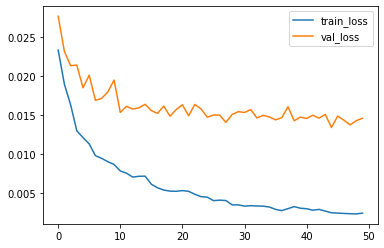

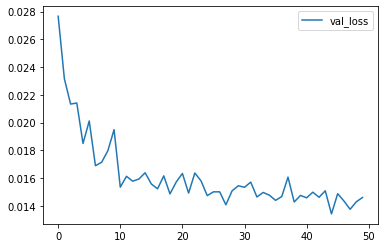

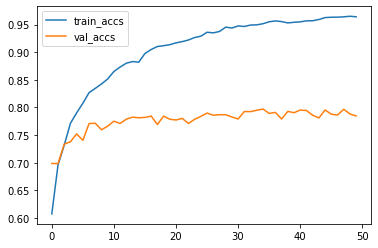

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_losses[:], label='train_loss')
plt.plot(val_losses[:], label='val_loss')
plt.legend()
plt.savefig('train_losses')
plt.show()

plt.plot(val_losses[:], label='val_loss')
plt.legend()
plt.savefig('val_losses')
plt.show()

plt.plot(train_accs, label='train_accs')
plt.plot(val_accs, label='val_accs')
plt.legend()
plt.savefig('accuracies')
plt.show()

## Part 4. Evaluation 


In [12]:
from test import evaluate_test_set

load_model=True
if load_model:
    best_model = SiameseBiLSTMAttention(
        batch_size=batch_size,
        vocab_size=vocab_size,
        embedding_size=embedding_size,

        embedding_weights=embedding_weights,
        attention_encoder_config=attention_encoder_config,
        device=device,
        pad_index=pad_index,
        dropout=dropout
    )
    ## move model to device
    best_model.to(device)
    best_model.load_state_dict(torch.load("siamese_lstm_attention.pth"))
    best_model.eval()


test_acc, r, rho, mse, least_1, least_2, most_1, most_2  = evaluate_test_set(
    model=best_model,
    data_loader=sick_dataloaders,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

print('final accuracy on test set is {}'.format(test_acc))
print('pearsons r test set is {}'.format(r))
print('spearman rho on test set is {}'.format(rho))
print('mean square error on test set is {}'.format(mse))

INFO:root:Evaluating accuracy on test set


Worst score is -0.34392204135656357 and should be 1.0
Best score is 5.000000596046448 and should be 5.0
tensor([   2,  294,    3, 1026,   40,  121,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
tensor([   2,  294,    3,   40,  121, 1026,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
final accuracy on test set is 0.5858996942640309
pearsons r test set is (0.8061555261904889, 0.0)
spearman rho on test set is SpearmanrResult(correlation=0.7506728391298879, pvalue=0.0)
mean square error on test set is 0.01687232404947281


In [14]:
worst_sen_1 = [sick_data.vocab.itos[token] for token in least_1]
print(worst_sen_1)
worst_sen_2 = [sick_data.vocab.itos[token] for token in least_2]
print(worst_sen_2)

best_sen_1 = [sick_data.vocab.itos[token] for token in most_1]
print(best_sen_1)
best_sen_2 = [sick_data.vocab.itos[token] for token in most_2]
print(best_sen_2)



## Test on some manual sentences
test_sentences1 = ['the cat sits outside <pad> <pad>',
             'a man is playing guitar <pad>',
             'the new movie is awesome <pad>',
             'the dog plays in the garden',
             'a woman working in an office']

test_sentences2 = ['the dog plays in the garden',
              'a woman watches TV <pad> <pad>',
              'the new movie is so great',
              'the dog plays in the garden',
              'a boy eating ice cream <pad>']

tokenized_sen1= list()             
for sentence in test_sentences1:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen1.append(tokenized)
tokenized_sen1 = torch.tensor(tokenized_sen1).to(device)

tokenized_sen2= list()             
for sentence in test_sentences2:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen2.append(tokenized)
tokenized_sen2=torch.tensor(tokenized_sen2).to(device)

predic = best_model(tokenized_sen1, tokenized_sen2)

for i in range(len(test_sentences1)):
    print('similarity: {:.2f} for sentences  {} - {}'.format(predic[i]*5.0, test_sentences1[i], test_sentences2[i]))


['a', 'girl', 'is', 'tapping', 'her', 'fingernails', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['a', 'big', 'dog', 'is', 'running', 'on', 'the', 'ground', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['a', 'tiger', 'is', 'aimlessly', 'walking', 'around', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['a', 'tiger', 'is', 'walking', 'around', 'aimlessly', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

## Visualisation

In [15]:
from utils import plot_attention_maps

## Get a batch of tokenized test set sentences
(sent1,sent2,sents1_len,sents2_len,targets,_,_,) = next(iter(sick_dataloaders['test']))

## forward pass and extract multi head attention matrices
predic = best_model(sent1.to(device), sent2.to(device))
sent_A_mh_att_matrix = best_model.sent_A_mh_att_matrix
sent_B_mh_att_matrix = best_model.sent_B_mh_att_matrix

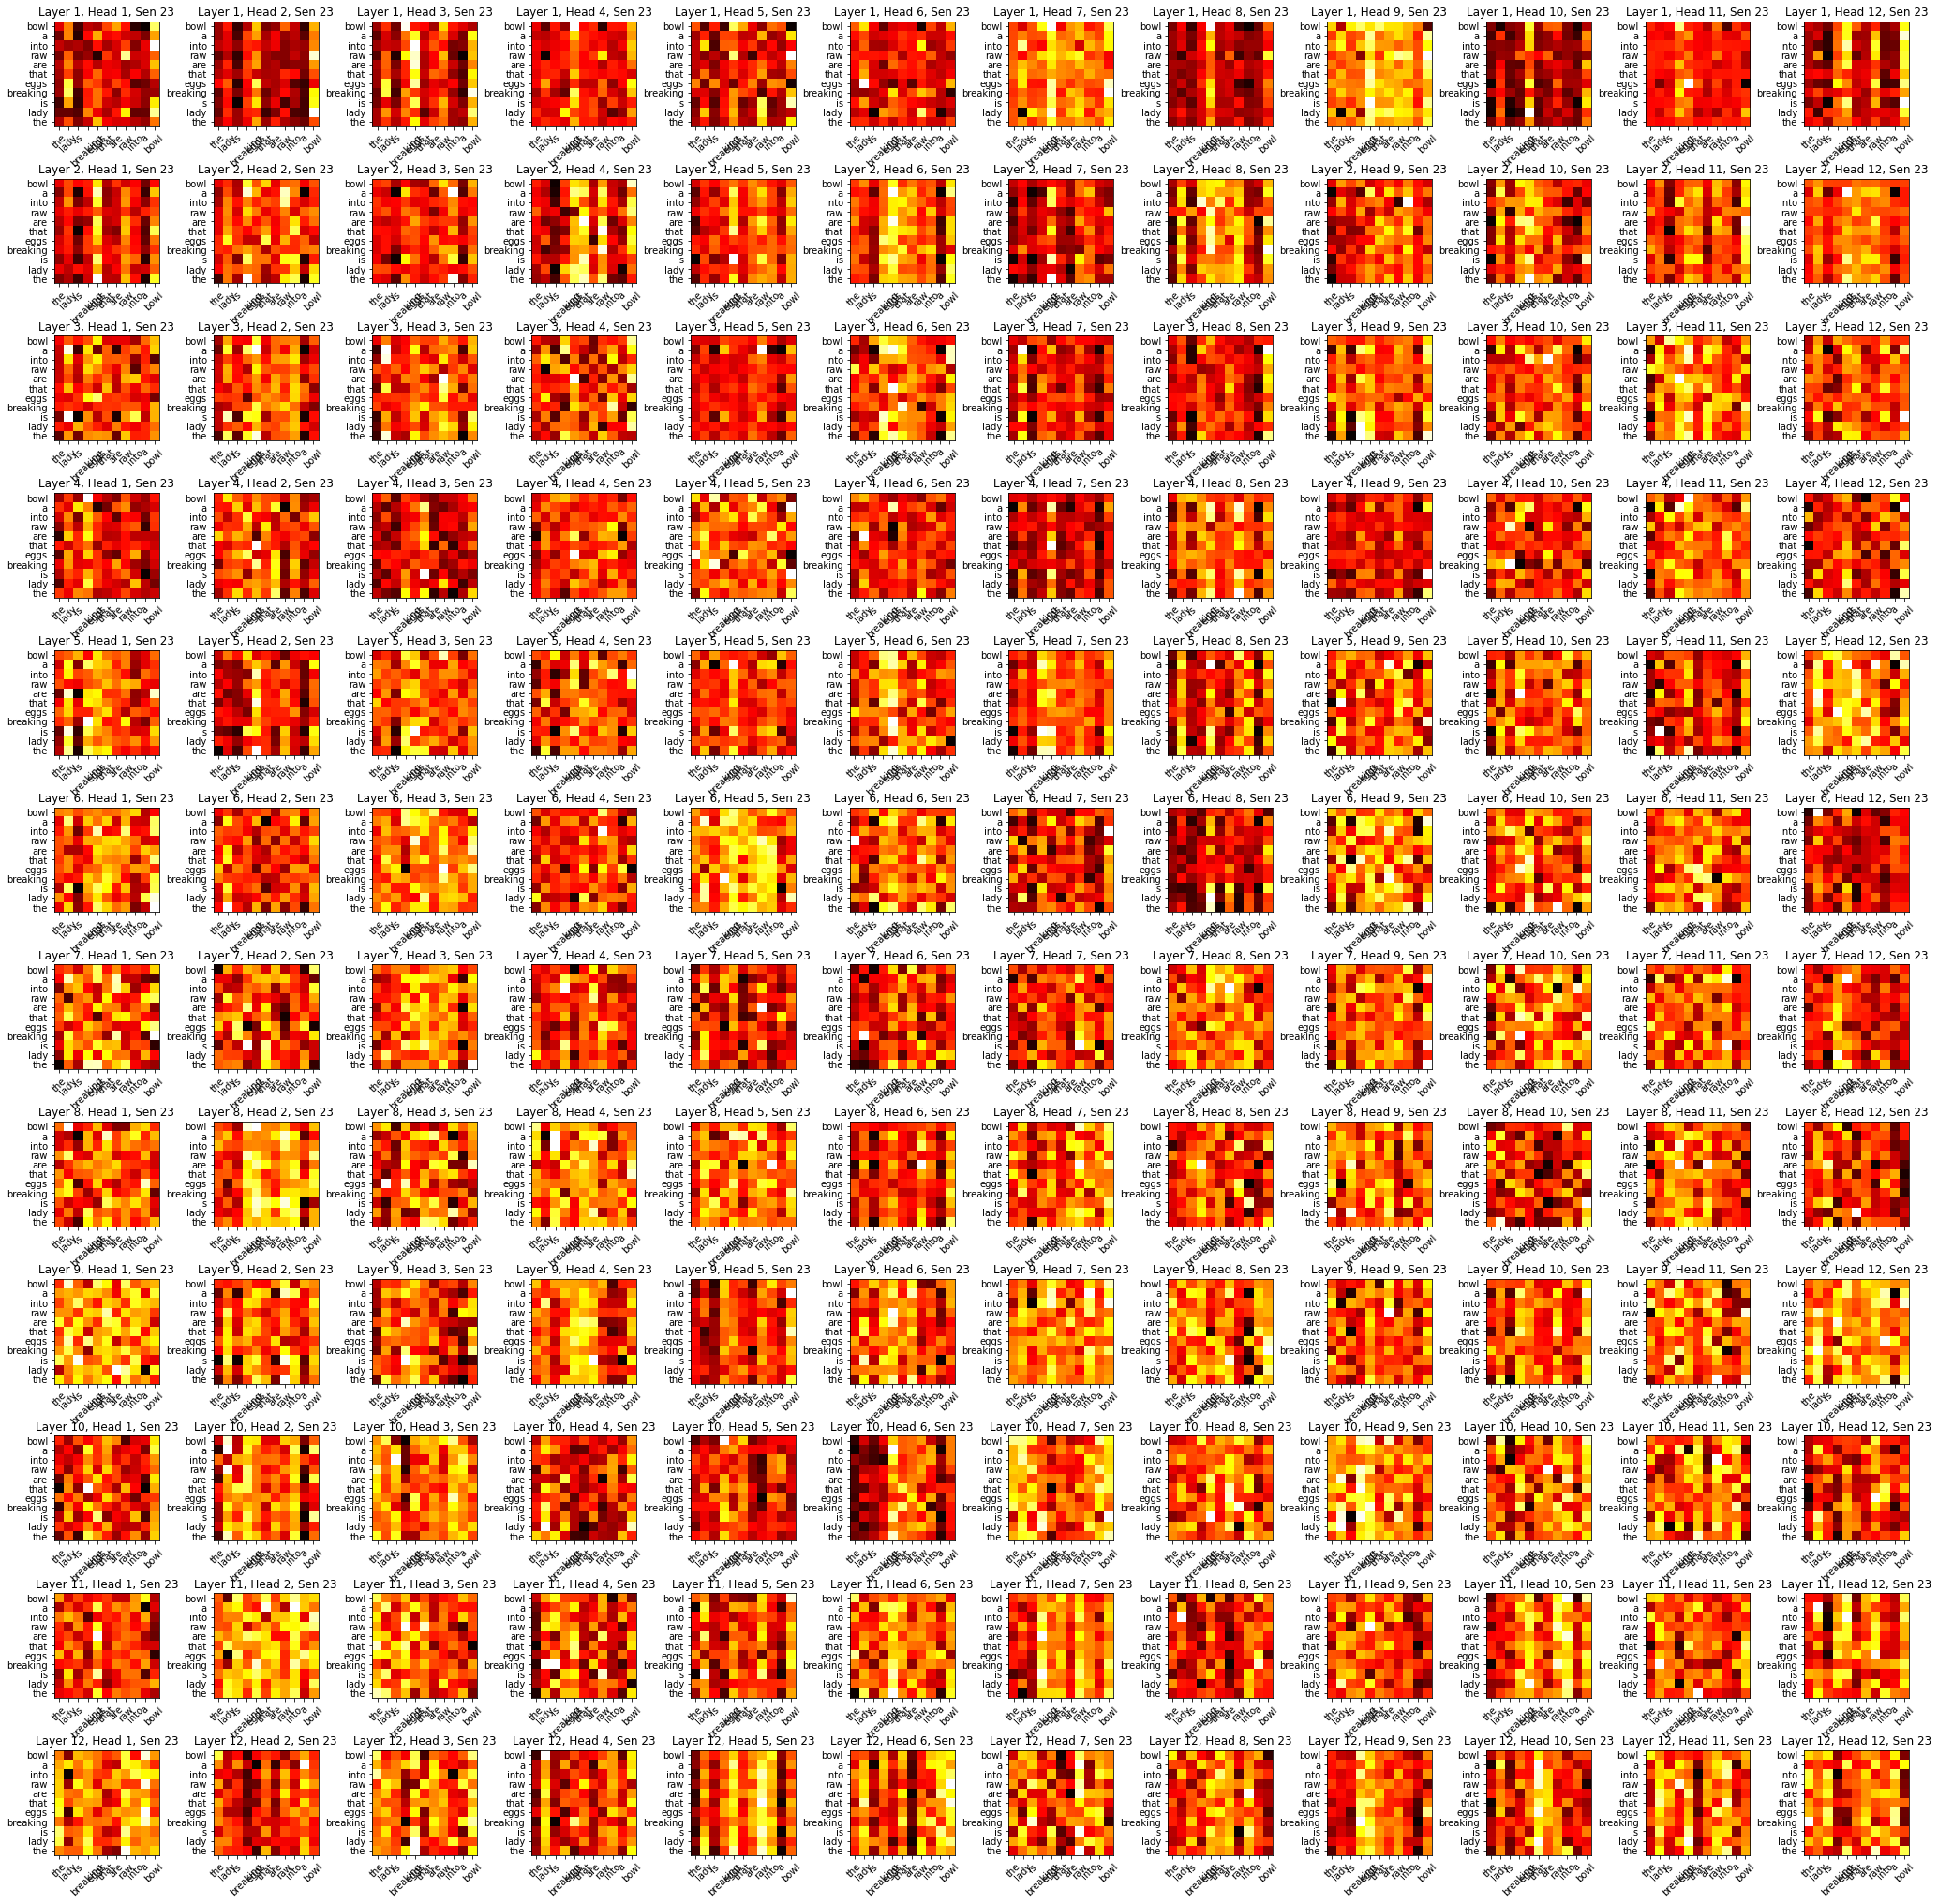

In [16]:
# for i in range(len(tokenized_sen1)):
#     plot_attention_maps(sent1, sent_A_mh_att_matrix, i)
#     plot_attention_maps(sent2, sent_B_mh_att_matrix, i)
plot_attention_maps(sent1, sent_A_mh_att_matrix, 23, save=False, use_words=True, sick_data=sick_data)